# Inverse graphics using graphics-based generative models and MCMC

We will start with installing the neccesary packages: mitsuba for differentiable rendering and numpy for numerical processing. 

We will install `mitsuba` and `numpy` using `Conda.jl`. The following snippet will create a local environment that will allow you to install things on the Apptainer container (and on your own computer). 

In [1]:
using Pkg
Pkg.activate("psyc261")
Pkg.add("Conda")
using Conda
Conda.add("numpy")

  Activating project at `~/Algorithms-of-the-Mind/labs/lab-05/psyc261`
   Resolving package versions...
  No Changes to `~/Algorithms-of-the-Mind/labs/lab-05/psyc261/Project.toml`
  No Changes to `~/Algorithms-of-the-Mind/labs/lab-05/psyc261/Manifest.toml`
[ Info: Running `conda install -y numpy` in root environment


Channels:
 - conda-forge
Platform: linux-64
Solving environment: ...working... done




==> WARNING: A newer version of conda exists. <==
    current version: 25.7.0
    latest version: 25.9.0

Please update conda by running

    $ conda update -n base -c conda-forge conda





# All requested packages already installed.



In [2]:
# need this for installing mitsuba...

run(`conda config --set pip_interop_enabled true`)
run(`pip install mitsuba`)

Defaulting to user installation because normal site-packages is not writeable


Process(`pip install mitsuba`, ProcessExited(0))

In [3]:
Pkg.add(["Distributions", "ProgressMeter", "Gen", "Plots", "Parameters", "PyCall"])

   Resolving package versions...
  No Changes to `~/Algorithms-of-the-Mind/labs/lab-05/psyc261/Project.toml`
  No Changes to `~/Algorithms-of-the-Mind/labs/lab-05/psyc261/Manifest.toml`


In [4]:
using Pkg
using Distributions
using ProgressMeter
using Gen, Plots
using Parameters
using PyCall
np = pyimport("numpy")
;

# Part 0: The task

The task in this lab is to build a probabilistic inverse graphics model: The model will go from a 2D image to a 3D scene inference (aka single-image 3D reconstruction). We will do so by inverting a graphics-based generative model of images.  

# Part 1: Compute graphics & `mitsuba`
## Mini introduction to computer graphics

Computer graphics are concerned with algorithmically tractable methods for representing 3D scenes (static or dynamic) and syntesizing realistic (or non-realistic) imagery based off of these scenes. Rendering is the process of synthesizing an image from a 3D (or a 2D) scene via a computer program. We will refer to such computer programs as *rendering engines*.

<img src="./images/render.png" alt="" width="400"/>

In a rendering engine, a 3D scene is defined by 4 basic ingredients:

1. Objects (e.g., 3D shapes and surfaces)
2. Optical material properties (how the surface of an object is supposed to reflect light; e.g., glass-like, diffuse, opaque, transparent, shiny, etc.)
3. Lights
4. Sensors or camera

This course is obviously not about developing rendering engines -- [see the relevant courses](https://courses.yale.edu/?keyword=computer%20graphics) offered by the Department of Computer Science and numerous resources online. Instead, we will use existing rendering engines, embedding them within probabilistic models.

To create a 3D scene and generate an image, you need to provide the rendering engine (`mitsuba` in our case) with each of the four ingredients described earlier (objects, optical material properties, lights, and sensors/cameras).

## Mini introduction to Mitsuba3

The field of computer graphics has developed many algorithms for realistic image synthesis. At the highest level, rendering engines can be categorized into:
1. real-time renderers (rasterization renderers, etc.), or
2. physically-based renderers (ray-traced renderers, etc.).

`mitsuba` is a **physically-based renderer**. This means that it sends "rays" from the camera out into the scene and tracks where and how they intersect light sources. These rays are then integrated to figure out what color to paint on each pixel in an image. (Here's an informative [tutorial on ray tracing](https://youtu.be/gsZiJeaMO48). _This is not relevant material for PSYC 261._)

<img src="./images/raytracing.png" alt="" width="400"/>

Like other rendering engines, we need to input a scene to `mitsuba` (lights, optical materials, objects, sensory). This can be done using XML or a Python dictionary. We provide examples of both below. 

In this course, we chose to work with mitsuba3 because it is open source software, and has some exciting attributes (many of which we will not get into in this lab), notably, differentiable rendering capabilities. Additionally, in ongoing research in Ilker's lab, `mitsuba` has proven to be dependable for its numerical stability and customizability for probabilistic inference. 

Please see the [tutorials](https://www.youtube.com/watch?v=9Ja9buZx0Cs&list=PLI9y-85z_Po6da-pyTNGTns2n4fhpbLe5) and [documentation](https://mitsuba.readthedocs.io/en/stable/) on Mitsuba3's [official website](https://www.mitsuba-renderer.org/) for more. 

**Notice that `mitsuba` is a Python package**; to use it we rely on the `PyCall` package of Julia, which provides a native interface to python code. You can familiarize yourself with PyCall [here](https://github.com/JuliaPy/PyCall.jl#usage).

# Part 2: Using `mitsuba`

## Getting started with `mitsuba`

In this tutorial, we will learn about how to load a scene and render it. Mitsuba3 gives a lot of fun flexibility, especially in terms of rendering. 

Before we start, let's execute our very first command with mitsuba3.

In [5]:
# import mitsuba using pycall
mi = pyimport("mitsuba")

# different rendering modes of mitsuba 
# for our purposes, we wish to highlight the differentiable vs. scalar modes
mi.variants()

13-element Vector{String}:
 "scalar_rgb"
 "scalar_spectral"
 "scalar_spectral_polarized"
 "llvm_ad_rgb"
 "llvm_ad_mono"
 "llvm_ad_mono_polarized"
 "llvm_ad_spectral"
 "llvm_ad_spectral_polarized"
 "cuda_ad_rgb"
 "cuda_ad_mono"
 "cuda_ad_mono_polarized"
 "cuda_ad_spectral"
 "cuda_ad_spectral_polarized"

Now the output of this function `mi.variants()` tells us that mitsuba3 can render a scene in 4 different modes. We will be using the `scalar_rgb` mode in this lab, which will render a standard RGB image.

To use `mitsuba`'s differentiable rendering functionality, we would need to be either `cuda_ad_rgb` or `llbm_ad_rgb` modes. This will not be explored in lab. Check the `mitsuba` documentation and tutorials for this advanced topic.

### Loading and rendering a scene (objects, lights, materials, sensors) in `mitsuba`

Here we will first set our mode of rendering to be `scalar_rgb`.

Then, we will load a scene with with two cuboids in a room with differently colored walls. We will then render it.

The scene description will be loaded from a python dictionary based on an example from the mitsuba3 gallery. Run this code and review its output to appreciate how it defines each of the four kinds of elements we are talking about: shapes, lights, optical materials (jargon name: BSDFs), and sensors.

`OBJMesh` are the walls, `Sphere` is a shape; things like `SmoothDiffuse` are optical material properties; `emitter`s are lights; and `PerspectiveCamera` is the sensor. Notice how each entry has certain properties: For example an object needs to define where it is in the world (`to_world`) and its optical material property.

You can also review `cbox-generic.xml` under this folder to again appreciate what goes into a scene.

In [6]:
mi.set_variant("scalar_rgb")

@pyinclude("./cbox-generic.py")

scene_d = py"initialize_scene()"o::PyObject

# load the scene using the load_dict function
scene::PyObject = @pycall mi.load_dict(scene_d)::PyObject

PyObject Scene[
  children = [
    PathIntegrator[
      max_depth = 6,
      rr_depth = 5
    ],
    PerspectiveCamera[
      x_fov = 39.3077,
      near_clip = 0.001,
      far_clip = 100,
      film = HDRFilm[
        size = [64, 64],
        crop_size = [64, 64],
        crop_offset = [0, 0],
        sample_border = 0,
        compensate = 0,
        filter = TentFilter[radius=1.000000],
        file_format = OpenEXR,
        pixel_format = rgb,
        component_format = float32,
      ],
      sampler = IndependentSampler[
        base_seed = 0
        sample_count = 16
        samples_per_wavefront = 1
        wavefront_size = 0
      ],
      resolution = [64, 64],
      shutter_open = 0,
      shutter_open_time = 0,
      to_world = [[-1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, -1, 4],
                  [0, 0, 0, 1]]
    ],
    SmoothDiffuse[
      reflectance = SRGBReflectanceSpectrum[
        value = [0.85, 0.85, 0.85]
      ]
    ],
    TwoSided[


Recall that we mentioned `mitsuba` is a physically-based renderer that estimates the color of each pixel using ray tracing. Ray-tracing is a computationally costly operation and `mitsuba` allows you to make a tradeoff that suits your goals. 

The parameter `spp`, which stands for samples per pixel and is input to the `mi.render` function below, is essentially the number of rays cast to compute the color per pixel. The choice of spp reflects a tradeoff: The greater the `spp`, the higher the quality and realism of our render is, with the expense of higher computational cost. You can reduce `spp` to obtain lower quality renders, which is often acceptable, especially for characterizing an approximate process of rendering that may be implemented in the mind and brain. (Regardless, this will be handy when we are doing probabilistic inference later on.) 

In [7]:
# set spp to 12 -- play with different values
spp = 128

# render the scene
image = @pycall mi.render(scene, spp=spp)::PyObject
# get the bitmap, which Jupyter notebook displays inline!
bitmap = @pycall mi.Bitmap(image).convert(srgb_gamma=true)::PyObject

PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

Wow! How cool is that?! You just rendered a nice scene with umm spheres in it. Yay for you! 

### Transformations of scene elements using `mitsuba`

Now a critical component of computer graphics is to manipulate the scene -- including adding, deleting, changing, moving (translating) and scaling the things in a scene. Here we will learn how we can translate and scale one of the cuboids in the scene. 

There are multiple ways in which one can transform the scene elements. See this mitsuba3 [tutorial](https://mitsuba.readthedocs.io/en/stable/src/rendering/editing_a_scene.html) for an approach we will not use in this lab.

The approach we will take is to update the dictionary that contains the scene configuration -- `scene_d` using mitsuba3's [transformation library](https://mitsuba.readthedocs.io/en/stable/src/how_to_guides/transformation_toolbox.html#Transform). 

We will transform the sphere on the right -- `right-object`. 

Let's first see the entry for `right-object` in `scene_d` dictionary.

In [8]:
println(get(scene_d, "right-object", true))

Dict{Any, Any}("to_world" => PyObject Transform[
  matrix=[[0.5, 0, 0, 0.5],
          [0, 0.5, 0, -0.75],
          [0, 0, 0.5, -0.2],
          [0, 0, 0, 1]],
  inverse_transpose=[[2, 0, 0, 0],
                     [0, 2, 0, 0],
                     [0, 0, 2, 0],
                     [-1, 1.5, 0.4, 1]]
], "rightobject-bsdf" => Dict{Any, Any}("id" => "color-sphere", "type" => "ref"), "type" => "sphere")


The PyObject which is a 4x4 quantity is a combined transformation consisting of the size of the object and where it is. 

Scale: `[[0.5, 0, 0], [0, 0.5, 0], [0.0, 0, 0.5]]`

Translation: `[0.5, -0.75, -0.2]`

Let's assign a new size and modify the z-coordinate of its location.

In [9]:
object = "right-object"
# create a new transformation
translation = [0.5, -0.75, 0.7]
scale = 0.25 # we will make it a cube

# now create the transformation using mi's transformation toolbox
tranformation = @pycall mi.Transform4f.translate(translation).scale(scale)::PyObject
object_dict = PyObject(get(scene_d, object))
set!(object_dict, "to_world", tranformation)
set!(scene_d, object, object_dict)

PyObject {'to_world': Transform[
  matrix=[[0.25, 0, 0, 0.5],
          [0, 0.25, 0, -0.75],
          [0, 0, 0.25, 0.7],
          [0, 0, 0, 1]],
  inverse_transpose=[[4, 0, 0, 0],
                     [0, 4, 0, 0],
                     [0, 0, 4, 0],
                     [-2, 3, -2.8, 1]]
], 'rightobject-bsdf': {'id': 'color-sphere', 'type': 'ref'}, 'type': 'sphere'}

Now let's reload this updated dictionary into our scene and render it.

In [10]:
# load the scene using the load_dict function
scene = @pycall mi.load_dict(scene_d)::PyObject
image = @pycall mi.render(scene, spp=spp)::PyObject
# get the bitmap, which Jupyter notebook displays inline!
bitmap = @pycall mi.Bitmap(image).convert(srgb_gamma=true)::PyObject

PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

Notice how the right object became smaller than it was before and came closer to the sensor.

Okay now let's do some *inverse* graphics.

# Part 3: Inverse graphics & modeling

## Inverse graphics

We start by writing a Julia struct to hold the state of the scene -- including the scene parameters (`scene_d`), the `mitsuba` scene (`scene`), and the `spp`.

In [11]:
# the with_kw macro comes from the Parameters package 
# and is a handy macro for having default values to certain entries in a Julia struct.
@with_kw struct ModelParams
    scene_d::PyDict
    scene::PyObject = @pycall mi.load_dict(scene_d)::PyObject
    spp::Int32 = 16
end;

As further setup, let's also include the python file (included in this folder) that contains the scene configuration we will work with.

In [12]:
mi = pyimport("mitsuba")
mi.set_variant("scalar_rgb")
@pyinclude("./cbox-generic.py")

We will also define helper functions for 

* transformations (moving and scaling objects)
* rendering

In [13]:
function transform!(scene_d, object, scale, translation)
    transformation = @pycall mi.Transform4f.translate(translation).scale(scale)::PyObject
    object_dict = PyObject(get(scene_d, object))
    set!(object_dict, "to_world", transformation)
    set!(scene_d, object, object_dict)
    return scene_d
end

function render_bitmap(modelparams)
    image = @pycall mi.render(modelparams.scene, spp=modelparams.spp)::PyObject
    bitmap = @pycall mi.Bitmap(image).convert(srgb_gamma=true)::PyObject
    return bitmap
end

function render(modelparams)
    bitmap = render_bitmap(modelparams)
    mu = @pycall np.array(bitmap)::Array{Float32, 3}
    return mu[:, :, 1]
end
;

### Generative model

Now we will proceed with writing our generative model. 

The generative model will define a distribution over *images* parametrized by a scene configuration, a renderer, and the size of the objects in it. 

To keep things pedagogically tractable, the generative model will make a few assumptions. The generative model will assume that there are two objects in the scene -- two spheres (otherwise, the scene configuration will be the same room as above) --, the knowledge of where these spheres are, and the knowledge of the viewpoint (where the sensor is). Notice that you can relax each of these assumptions with appropriate prior distributions! 

The generative model will define priors over the sizes of the spheres. 

And the generative model will define a gaussian likelihood function (a la Erdogan & Jacobs, 2017) over images. 

The generative model will use a much cheaper rendering protocol by setting `spp=16` (instead of 128, which is what we will use to render the observation). This will mimick the default scenario where the internal representation can get by with much coarser processes than reality.

In [14]:
@gen function room()

    # load the scene configuration, including a room with colored walls, two spheres, lights, materials, and a sensor
    scene_d = py"initialize_scene()"o::PyObject
    
    # prior over the scale of the left sphere
    s_left ~ uniform(0.1, 1.0)
    # we assume we know a priori where this sphere will appear in the scene
    t_left = [-0.3, -0.5, 0.2]
    # transform the object in the scene according to this scale and translation parameters
    transform!(scene_d, "left-object", s_left, t_left)
    
    # prior over the scale of the right sphere
    s_right ~ uniform(0.1, 1.0)
    # we assume we know a priori where this sphere will appear in the scene
    t_right = [0.5, -0.75, -0.2] 
    # transform the object in the scene according to this scale and translation parameters
    transform!(scene_d, "right-object", s_right, t_right)

    # load the resulting scene into our struct
    # Notice that we are using a much cheaper spp for inference
    modelparams = ModelParams(scene_d=scene_d, spp=16)

    # render into an array
    mu = render(modelparams)

    # define the likelihood as a gaussian with diagonal covariance
    pred ~ broadcasted_normal(mu, 1.0)

end
;

We define a helper function `view_image` to render and visualize scenes using mitsuba3

In [15]:
function view_image(t)
    scene_d = py"initialize_scene()"o::PyObject
    t_left = [-0.3, -0.5, 0.2]
    transform!(scene_d, "left-object", t[:s_left], t_left)
    
    t_right = [0.5, -0.75, -0.2] 
    transform!(scene_d, "right-object", t[:s_right], t_right)
    #scene = mi.load_dict(scene_d)
    scene_to_render = ModelParams(scene_d=scene_d)
    bitmap = render_bitmap(scene_to_render)
end
;

Now we are ready to draw a sample from this generative model and visualize

In [16]:
# draw a random sample from the generative model
trace = Gen.simulate(room, ())
get_choices(trace)

│
├── :s_left : 0.989101263930576
│
├── :pred : [-0.9974813639976495 0.400119193841645 0.676986565564953 2.481351657437276 -1.062562505560783 -1.2376286412438389 0.9784302743882554 -0.8206335602289123 -0.5636848940824994 -1.5969896748257015 -0.9772101208935914 0.3600260458017178 0.3454055174986038 -0.36538418141028123 0.7171393886896582 -1.1924187950231746 3.1157557675540604 1.167881077356976 -0.3727236957484679 0.6971638443305709 1.0831842869182788 -1.677914195911715 1.24692162765237 1.4308592353064418 0.03213165160652762 -2.7153755444636127 0.8810938019971674 -0.12934890875060023 0.335473980978466 1.7998754517272595 0.8356262431110426 1.7711281092718696 0.18363685918111372 -1.8601394660232984 -2.678641403438977 0.9144754187074396 -0.3284855691611524 0.3473579924637422 -1.413804300760768 -1.5027803058433917 -0.8734054010527007 0.6761177774441777 0.7912549155980034 1.7701101464271658 -0.5313571655356537 -0.4746041249610113 -1.1022497170148542 0.6212504214424043 -0.6064888852633219 -0.1

In [17]:
view_image(trace)

PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

Now let's load a scene from mitsuba3's gallery and render it as our observed image

In [18]:
# load the scene from an xml file (instead of a dict)
obs_scene_config = mi.load_file("./scenes/cbox.xml")
obs_scene = ModelParams(scene_d=PyDict(), scene=obs_scene_config, spp=128)
obs_bitmap = render_bitmap(obs_scene)
obs_image = Gen.choicemap()
p = @pycall np.array(obs_bitmap)::Array{Float64, 3}
obs_image[:pred] = p[:, :, 1]
# again, hoping to avoid that nasty bug...
obs_scene = 1
# to view the image on your notebook
obs_bitmap

PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

### Inference: Random walk MH

We will implement a simple random walk MH procedure. In particular, we will make (truncated) gaussian proposals over the sizes of each of the two spheres in the scene. Otherwise, this is super off-the-shelf MCMC code in Gen.

In [19]:
# include the truncated norm distribution
include("truncatednorm.jl")

Define proposals for perturbing the two latent variables in the generative model

In [20]:
# proposal distribution for the scale variables
@gen function scale_proposal(current_trace)
    # trunc_norm(mean, std, lower_bound, upper_bound)
    # why do we need a truncated norm, instead of a regular normal distribution?
    s_left ~ trunc_norm(current_trace[:s_left], 0.25, 0.01, 1.)
    s_right ~ trunc_norm(current_trace[:s_right], 0.25, 0.01, 1.)
end
;

The inference procedure couldn't really get any simpler: Make MH moves on the two latents and that's all.

In [21]:
function random_walk_mh(tr)
    # make a random-walk update on scale variables
    (tr, accepted) = mh(tr, scale_proposal, ())

    # return the updated trace
    tr
end
;

Now call this inference procedure in an iterative loop -- notice that we are going for a rather small number of iterations -- `K=50` -- let's see if this works!

In [22]:
function do_inference()
    K = 100
    t, = generate(room, (), obs_image)
    scores = Vector{Float64}(undef, K)
    @showprogress for i in 1:K
        t = random_walk_mh(t)
        scores[i] = get_score(t)
    end;
    return scores, t
end
;

In [23]:
# call the inference procedure
(scores, t) = do_inference()

Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


([-3801.753595763265, -3801.753595763265, -3800.3713876029274, -3800.3713876029274, -3800.3713876029274, -3800.3713876029274, -3800.3713876029274, -3800.3713876029274, -3789.2293536746442, -3789.2293536746442  …  -3788.4714282125583, -3788.4714282125583, -3788.4714282125583, -3788.4714282125583, -3788.4714282125583, -3788.4714282125583, -3788.4714282125583, -3788.4714282125583, -3788.4714282125583, -3788.4714282125583], Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##room#292", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:s_left => Gen.ChoiceOrCallRecord{Float64}(0.4416255286816788, 0.10536051565782628, NaN, true), :pred => Gen.ChoiceOrCallRecord{Matrix{Float64}}([0.0 0.0 … 0.0 0.0; 0.0 0.0010951956501230597 … 0.005541663616895676 0.0; … ; 0.0 0.006749952677637339 … 0.00588970584794879 0.0; 0.0 0.0 … 0.0 0.0], -3788.682149243874, NaN, 

Now, how do I know if my inference procedure worked? 

Let's first visualize to see if our log likelihood scores improved over iterations (x-axis: iterations; y-axis: log scores).

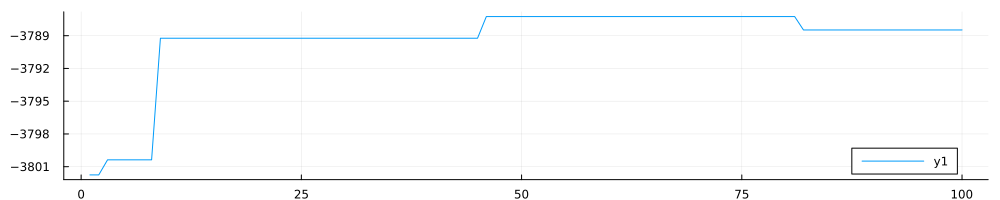

In [24]:
plot(scores, size = (1000, 200))

Alright this should look good. Try to reason about how often proposals are accepted by the step-wise changes in the loglikelihood scores over iterations.

Now let's find out what our inferred scene looks like at the end of the procedure:

In [25]:
view_image(t)

PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

Compare the image that your model synthesized to what the observation was like from above. Did the inference procedure work reasonably well? Try changing the number of iterations. 

## Taking stock:

Notice what we have accomplished: The result of the inference procedure is not just a reconstructed image -- rather, it is a causal explanation that goes far beyond what was in the image: a 3D scene that we can re-light, re-pose, and manipulate. The result of inference